![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

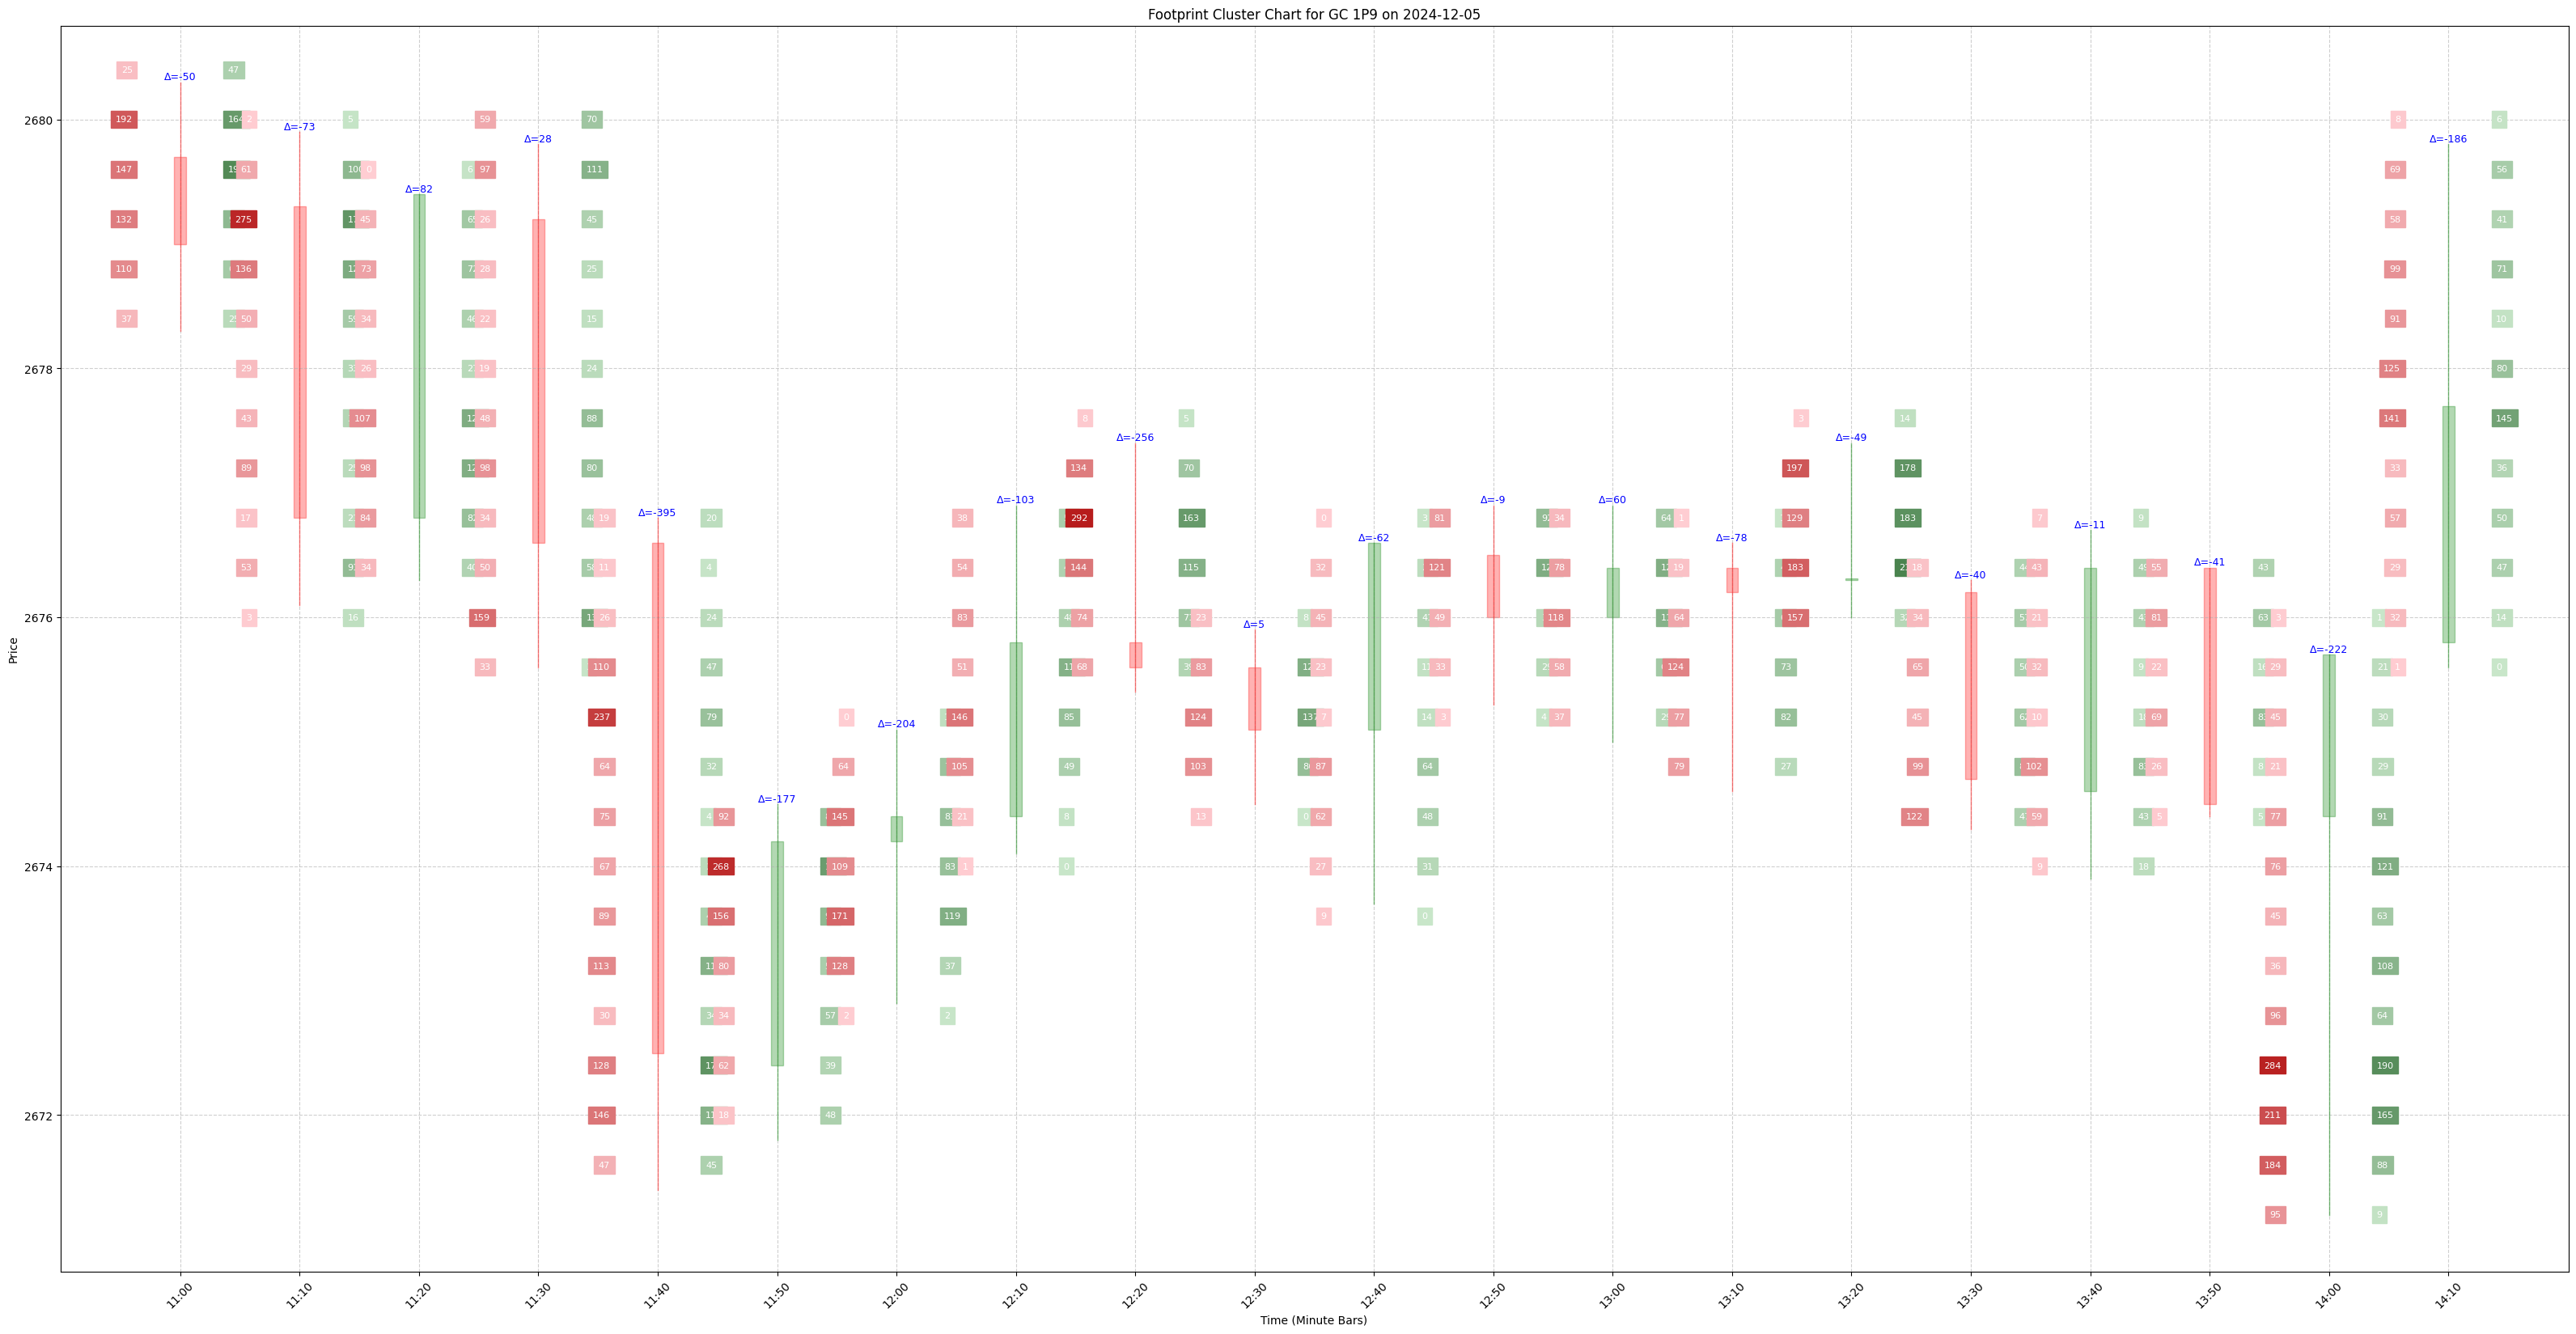

In [4]:
#region imports
from AlgorithmImports import *
#endregion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from footprint_consolidator import FootprintConsolidator
from footprint_utils import price_to_bucket
from datetime import datetime, timedelta
from collections import defaultdict # 新增导入

# --- 1. 初始化和历史数据请求 ---
qb = QuantBook()
symbol = qb.add_future(Futures.Metals.GOLD, Resolution.SECOND).symbol

qb.set_time_zone(TimeZones.HONG_KONG)

history_date = datetime(2024, 12, 5)

df_history = qb.history(symbol, history_date, history_date + timedelta(days=1),
                        resolution=Resolution.SECOND,
                        extended_market_hours=True,
                        data_mapping_mode=DataMappingMode.OPEN_INTEREST_ANNUAL, # 数据映射模式，这个会根据交易量切换到当年后续更大的合约，Warning, 但正确性有待验证
                        data_normalization_mode=DataNormalizationMode.RAW, # 数据连续模式，ATAS是RAW, tradingview 是BACKWARDS_RATIO，能够使得连续。注意，实盘需要使用当期合约数据
                        fill_forward=True
                        )
#print(df_history)

if df_history.empty:
    qb.Debug("No history data found for the selected date or symbol.")
else:
    # --- 2. 使用新的静态方法处理历史数据 ---
    target_period = timedelta(minutes=10)
    sec = qb.Securities[symbol]
    tick_size = sec.SymbolProperties.MinimumPriceVariation
    
    footprint_bars = FootprintConsolidator.create_from_history(df_history, target_period, tick_size)

    # --- 3. 可视化 ---
    if footprint_bars:
        # 新增：定义价格合并因子
        group_tick_factor = 4 
        merged_tick_size = tick_size * group_tick_factor

        # 选择要绘制的时间段
        footprint_subset = footprint_bars[:20] # 只绘制前30个FootprintBar
        
        fig, ax = plt.subplots(figsize=(40, 20))
        
        red_cmap = LinearSegmentedColormap.from_list("custom_red", ["#FFCDD2", "#B71C1C"])
        green_cmap = LinearSegmentedColormap.from_list("custom_green", ["#C8E6C9", "#1B5E20"])

        bar_width = 0.8
        bar_padding = 0.2

        # --- 重新计算最大成交量，以适应合并后的价格级别 ---
        all_aggregated_volumes = []
        for fp_bar in footprint_subset:
            aggregated_volume_at_price = defaultdict(lambda: {"bid": 0.0, "ask": 0.0})
            for price_bucket, volumes in fp_bar.volume_at_price.items():
                # 将原始价格桶合并到新的更大价格桶中
                merged_bucket_price = price_to_bucket(price_bucket, merged_tick_size)
                aggregated_volume_at_price[merged_bucket_price]["bid"] += volumes["bid"]
                aggregated_volume_at_price[merged_bucket_price]["ask"] += volumes["ask"]
            all_aggregated_volumes.extend([v["bid"] for v in aggregated_volume_at_price.values()])
            all_aggregated_volumes.extend([v["ask"] for v in aggregated_volume_at_price.values()])

        max_vol = max(all_aggregated_volumes) if all_aggregated_volumes else 1 # 避免除以零


        # 绘制每个分钟的K线和Cluster
        for i, fp_bar in enumerate(footprint_subset):
            x_pos = i * (bar_width + bar_padding)
            
            # 绘制K线实体
            if fp_bar.close >= fp_bar.open:
                rect_color = 'green'
                body_bottom = fp_bar.open
                body_height = fp_bar.close - fp_bar.open
            else:
                rect_color = 'red'
                body_bottom = fp_bar.close
                body_height = fp_bar.open - fp_bar.close
            
            # 如果body_height为0，给一个最小高度以便能够看到
            if body_height == 0:
                body_height = tick_size * 0.1
                
            rect = patches.Rectangle((x_pos - 0.05, body_bottom), 0.1, body_height, linewidth=1, edgecolor=rect_color, facecolor=rect_color, alpha=0.3)
            ax.add_patch(rect)
            
            # 绘制影线
            ax.plot([x_pos, x_pos], [fp_bar.low, fp_bar.high], color=rect_color, linewidth=1, alpha=0.5)

            # --- Footprint Cluster 聚合显示 ---
            aggregated_volume_at_price = defaultdict(lambda: {"bid": 0.0, "ask": 0.0})
            for price_bucket, volumes in fp_bar.volume_at_price.items():
                merged_bucket_price = price_to_bucket(price_bucket, merged_tick_size)
                aggregated_volume_at_price[merged_bucket_price]["bid"] += volumes["bid"]
                aggregated_volume_at_price[merged_bucket_price]["ask"] += volumes["ask"]
            
            # 对合并后的价格进行排序，以便于绘制
            sorted_aggregated_prices = sorted(aggregated_volume_at_price.keys())

            total_delta = fp_bar.delta # Delta 依然使用原始 FootprintBar 的总 Delta

            for price in sorted_aggregated_prices:
                volumes = aggregated_volume_at_price[price]
                
                # 绘制卖出量
                sell_vol_str = f"{int(volumes['bid'])}"
                sell_color = red_cmap(volumes['bid'] / max_vol if max_vol > 0 else 0)
                ax.text(x_pos - bar_width/2, price, sell_vol_str, ha='right', va='center', fontsize=8, color='white', backgroundcolor=sell_color)
                
                # 绘制买入量
                buy_vol_str = f"{int(volumes['ask'])}"
                buy_color = green_cmap(volumes['ask'] / max_vol if max_vol > 0 else 0)
                ax.text(x_pos + bar_width/2, price, buy_vol_str, ha='left', va='center', fontsize=8, color='white', backgroundcolor=buy_color)
                
            # 在K线顶部显示Delta
            ax.text(x_pos, fp_bar.high, f"Δ={int(total_delta)}", ha='center', va='bottom', fontsize=9, color='blue')

        ax.set_title(f"Footprint Cluster Chart for {symbol.ID} on {history_date.date()}")
        ax.set_xlabel("Time (Minute Bars)")
        ax.set_ylabel("Price")
        
        # 格式化X轴标签
        ax.set_xticks([i * (bar_width + bar_padding) for i in range(len(footprint_subset))])
        ax.set_xticklabels([fp.time.strftime('%H:%M') for fp in footprint_subset], rotation=45)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        qb.Debug("No FootprintBar data was generated from the history.")
